In [1]:
import base64
import functools
from io import BytesIO
import os
import warnings
warnings.filterwarnings(action='ignore')

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
from ipywidgets import interact
from matplotlib import cm
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import rdkit
from rdkit import Chem, RDPaths
from rdkit.Chem import AllChem,  DataStructs, Draw, rdBase, rdCoordGen, rdDepictor
from rdkit.Chem.Draw import IPythonConsole, rdMolDraw2D, SimilarityMaps
from rdkit.ML.Descriptors import MoleculeDescriptors
print(f'RDKit: {rdBase.rdkitVersion}')
import scipy
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import seaborn as sns
import shap
print(f'SHAP: {shap.__version__}')
from tqdm import tqdm_notebook as tqdm

RDKit: 2019.03.4
SHAP: 0.33.0


In [2]:
sns.set_style("whitegrid")

In [3]:
shap.initjs()

## Function Settings

In [4]:
# from chainer-chemistry's visualizer_utils.py
def red_blue_cmap(x):
    """Red to Blue color map
    Args:
        x (float): value between -1 ~ 1, represents normalized saliency score
    Returns (tuple): tuple of 3 float values representing R, G, B.
    """
    if x > 0:
        # Red for positive value
        # x=0 -> 1, 1, 1 (white)
        # x=1 -> 1, 0, 0 (red)
        return 1.0, 1.0 - x, 1.0 - x
    else:
        # Blue for negative value
        x *= -1
        return 1.0 - x, 1.0 - x, 1.0

def is_visible(begin, end):
    if begin <= 0 or end <= 0:
        return 0
    elif begin >= 1 or end >= 1:
        return 1
    else:
        return (begin + end) * 0.5
    
def color_bond(bond, saliency, color_fn):
    begin = saliency[bond.GetBeginAtomIdx()]
    end = saliency[bond.GetEndAtomIdx()]
    return color_fn(is_visible(begin, end))

In [5]:
def moltopng(mol, atom_colors, bond_colors, molSize=(450,150),kekulize=True):
    mc = Chem.Mol(mol.ToBinary())
    if kekulize:
        try:
            Chem.Kekulize(mc)
        except:
            mc = Chem.Mol(mol.ToBinary())
    if not mc.GetNumConformers():
        rdDepictor.Compute2DCoords(mc)
    drawer = rdMolDraw2D.MolDraw2DCairo(molSize[0],molSize[1])
    drawer.drawOptions().useBWAtomPalette()
    drawer.drawOptions().padding = .2
    drawer.DrawMolecule(
        mc,
        highlightAtoms=[i for i in range(len(atom_colors))], 
        highlightAtomColors=atom_colors, 
        highlightBonds=[i for i in range(len(bond_colors))],
        highlightBondColors=bond_colors,
        highlightAtomRadii={i: .5 for i in range(len(atom_colors))}
    )
    drawer.FinishDrawing()
    return drawer.GetDrawingText()

def label_cat(label):
    return '$+$' if bool(label!=0) else '$\cdot$'

In [6]:
# https://iwatobipen.wordpress.com/2017/02/25/draw-molecule-with-atom-index-in-rdkit/
def mol_with_atom_index(mol):
    import copy
    atoms = mol.GetNumAtoms()
    molwithidx = copy.deepcopy(mol)
    for idx in range( atoms ):
        molwithidx.GetAtomWithIdx( idx ).SetProp( 'molAtomMapNumber', str( molwithidx.GetAtomWithIdx( idx ).GetIdx() ) )
    return molwithidx

In [7]:
def draw_mols_with_idx(mol, atom_colors, bond_colors):
    images = []
    _img = moltopng(mol, atom_colors, bond_colors, molSize=(600, 400))
    output = BytesIO()
    output.write(_img)
    encoded_string = base64.b64encode(output.getvalue()).decode()
    images.append(f"<img style='width: 420px; margin: 0px; float: left; border: 0px solid black;' src='data:_img/png;base64,{encoded_string}' />")
    _img = moltopng(mol_with_atom_index(mol), {}, {}, molSize=(600, 400))
    output = BytesIO()
    output.write(_img)
    encoded_string = base64.b64encode(output.getvalue()).decode()
    images.append(f"<img style='width: 420px; margin: 0px; float: left; border: 0px solid black;' src='data:_img/png;base64,{encoded_string}' />")

    images = ''.join(images)
    display(HTML(images))

In [8]:
# weights = saliency
# add scaler argument
def plot_mol_saliency(mol, saliency, scaler=None, atoms=['C', 'N', 'O', 'S', 'F', 'Cl', 'P', 'Br']):
    n_atom = mol.GetNumAtoms()
    symbols = [f'{mol.GetAtomWithIdx(i).GetSymbol()}_{i}' for i in range(mol.GetNumAtoms())]
    df = pd.DataFrame(columns=atoms)
    saliency = saliency[:n_atom]
    num_atoms = mol.GetNumAtoms()
    if scaler is not None:
        vmax = np.max(np.abs(saliency))
        weights = scaler(saliency)
    else:
        weights, vmax = SimilarityMaps.GetStandardizedWeights(saliency)
    
    arr = np.zeros((num_atoms, len(atoms)))
    for i in range(mol.GetNumAtoms()):
        _a = mol.GetAtomWithIdx(i).GetSymbol()
        arr[i,atoms.index(_a)] = weights[i]
    df = pd.DataFrame(arr, index=symbols, columns=atoms)
    
    vmin = - vmax
    atom_colors = {i: red_blue_cmap(e) for i, e in enumerate(weights)}
    # bondlist = [bond.GetIdx() for bond in mol.GetBonds()]
    bond_colors = {i: color_bond(bond, weights, red_blue_cmap) for i, bond in enumerate(mol.GetBonds())}
    draw_mols_with_idx(mol, atom_colors, bond_colors)
    
    fig = plt.figure(figsize=(18, 9))
    grid = plt.GridSpec(15, 10)
    ax = fig.add_subplot(grid[1:, -1])
    ax.barh(range(mol.GetNumAtoms()), np.maximum(0, df.values).sum(axis=1), color='C3')
    ax.barh(range(mol.GetNumAtoms()), np.minimum(0, df.values).sum(axis=1), color='C0')
    ax.set_yticks(range(mol.GetNumAtoms()))
    ax.set_ylim(-.5, mol.GetNumAtoms()-.5)
    ax.axvline(0, color='k', linestyle='-', linewidth=.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.tick_params(axis='both', which='both', left=False, labelleft=False)

    ax = fig.add_subplot(grid[1:, :-1], sharey=ax)
    im = ax.imshow(df.values, cmap='bwr', vmin=vmin, vmax=vmax, aspect='auto')
    ax.set_yticks(range(mol.GetNumAtoms()))
    ax.set_ylim(mol.GetNumAtoms() -.5, -.5)
    symbols= {i: f'${mol.GetAtomWithIdx(i).GetSymbol()}_{{{i}}}$' for i in range(mol.GetNumAtoms())}
    ax.set_yticklabels(symbols.values())
    ax.set_xticks(range(len(atoms)))

    ax.set_xlim(-.5, len(atoms) -.5)
    ax.set_xticklabels(atoms, rotation=90)
    ax.set_ylabel('Node')

    for (j,i),label in np.ndenumerate(df.values):
        ax.text(i,j, label_cat(label) ,ha='center',va='center')
    ax.tick_params(axis='both', which='both', bottom=True, labelbottom=True, top=False, labeltop=False)
    ax.grid(b=None)


    ax = fig.add_subplot(grid[0, :-1])
    fig.colorbar(mappable=im, cax=ax, orientation='horizontal')
    ax.tick_params(axis='both', which='both', bottom=False, labelbottom=False, top=True, labeltop=True)

    display(fig)
    plt.close(fig)

## Training Random Forest/LightGBM Models

In [9]:
# https://iwatobipen.wordpress.com/2018/11/07/visualize-important-features-of-machine-leaning-rdkit/

def mol2fp(mol,radius=2, nBits=1024):
    bitInfo={}
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=nBits, bitInfo=bitInfo)
    arr = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr, bitInfo


train_path = os.path.join(RDPaths.RDDocsDir, 'Book/data/solubility.train.sdf')
test_path = os.path.join(RDPaths.RDDocsDir, 'Book/data/solubility.test.sdf')
train_mols = [m for m in Chem.SDMolSupplier(train_path) if m is not None]
test_mols = [m for m in Chem.SDMolSupplier(test_path) if m is not None]
len(train_mols), len(test_mols)

(1025, 257)

In [10]:
def show_pred_results(mol, model):
    y_pred = model.predict(mol2fp(mol)[0].reshape((1,-1)))
    sol_dict = {val: key for key, val in sol_classes.items()}
    print(f"True: {mol.GetProp('SOL_classification')} vs Predicted: {sol_dict[y_pred[0]]}")

In [11]:
sol_classes = {'(A) low': 0, '(B) medium': 1, '(C) high': 2}
X_train = np.array([mol2fp(m)[0] for m in train_mols])
y_train = np.array([sol_classes[m.GetProp('SOL_classification')] for m in train_mols], dtype=np.int) 
X_test = np.array([mol2fp(m)[0] for m in test_mols])
y_test = np.array([sol_classes[m.GetProp('SOL_classification')] for m in test_mols], dtype=np.int)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1025, 1024) (1025,) (257, 1024) (257,)


In [12]:
rf_models = []
clf = RandomForestClassifier(random_state=20200119)
clf.fit(X_train, y_train)
print(f'Train: {accuracy_score(y_train, clf.predict(X_train)):.3f}, Test: {accuracy_score(y_test, clf.predict(X_test)):.3f}')
rf_models.append(clf)
for _ in range(10):
    y_perm = np.random.permutation(y_train)
    _clf = RandomForestClassifier(random_state=20200119)
    _clf.fit(X_train, y_perm)
    rf_models.append(_clf)
    print(f'Shuffuled Data: {accuracy_score(y_perm, _clf.predict(X_train)):.3f}, True Train: {accuracy_score(y_train, _clf.predict(X_train)):.3f}, Test: {accuracy_score(y_test, _clf.predict(X_test)):.3f}')
          


Train: 0.992, Test: 0.685
Shuffuled Data: 0.985, True Train: 0.352, Test: 0.370
Shuffuled Data: 0.985, True Train: 0.371, Test: 0.401
Shuffuled Data: 0.985, True Train: 0.363, Test: 0.350
Shuffuled Data: 0.980, True Train: 0.368, Test: 0.358
Shuffuled Data: 0.981, True Train: 0.354, Test: 0.389
Shuffuled Data: 0.983, True Train: 0.365, Test: 0.389
Shuffuled Data: 0.984, True Train: 0.355, Test: 0.393
Shuffuled Data: 0.982, True Train: 0.363, Test: 0.444
Shuffuled Data: 0.986, True Train: 0.378, Test: 0.475
Shuffuled Data: 0.980, True Train: 0.359, Test: 0.401


In [13]:
np.sum(y_train != clf.predict(X_train))

8

True: (B) medium vs Predicted: (A) low


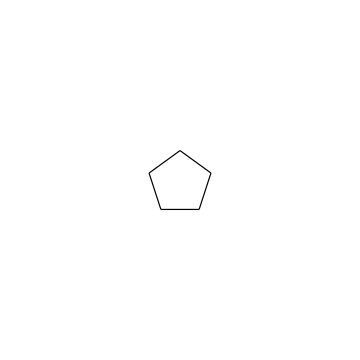

True: (B) medium vs Predicted: (A) low


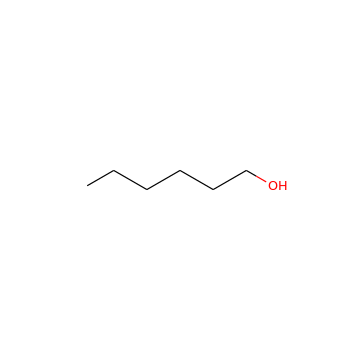

True: (B) medium vs Predicted: (A) low


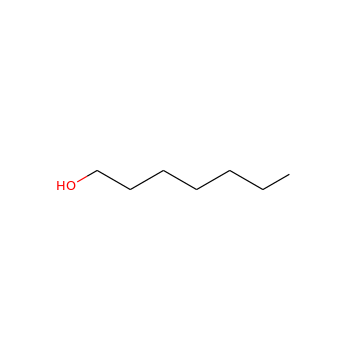

True: (B) medium vs Predicted: (A) low


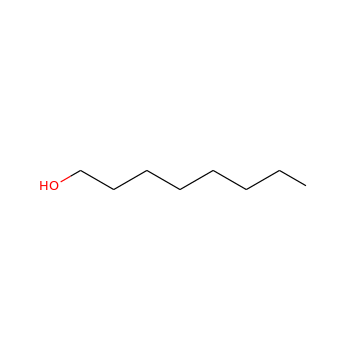

True: (A) low vs Predicted: (B) medium


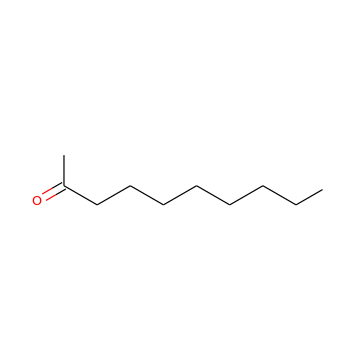

True: (B) medium vs Predicted: (A) low


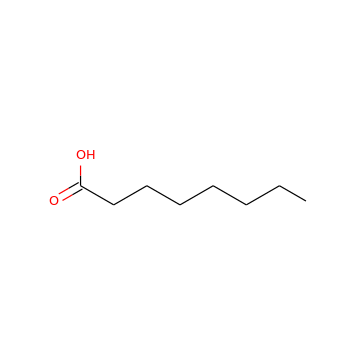

True: (B) medium vs Predicted: (A) low


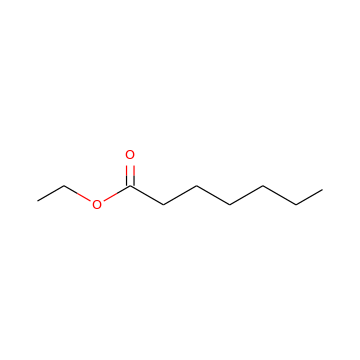

True: (A) low vs Predicted: (B) medium


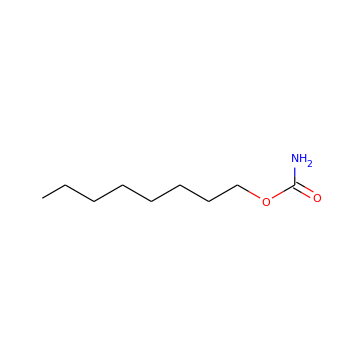

In [14]:
incorrect_mols = [train_mols[i] for i, flg in enumerate(y_train != clf.predict(X_train)) if flg==True]
for m in incorrect_mols:
    show_pred_results(m, clf)
    display(Draw.MolToImage(m, size=(360, 360)))

In [15]:
%%time
lgb_models = []
import lightgbm as lgb
_clf = lgb.LGBMClassifier(n_jobs=1)
_clf.fit(X_train, y_train)
print(f'Train: {accuracy_score(y_train, _clf.predict(X_train)):.3f}, Test: {accuracy_score(y_test, _clf.predict(X_test)):.3f}')
lgb_models.append(_clf)
    
for _ in range(10):
    y_perm = np.random.permutation(y_train)
    _clf = lgb.LGBMClassifier(n_jobs=1)
    _clf.fit(X_train, y_perm)
    lgb_models.append(_clf)
    print(f'Shuffuled Data: {accuracy_score(y_perm, _clf.predict(X_train)):.3f}, True Train: {accuracy_score(y_train, _clf.predict(X_train)):.3f}, Test: {accuracy_score(y_test, _clf.predict(X_test)):.3f}')
    



Train: 0.974, Test: 0.685
Shuffuled Data: 0.854, True Train: 0.391, Test: 0.393
Shuffuled Data: 0.860, True Train: 0.359, Test: 0.354
Shuffuled Data: 0.869, True Train: 0.338, Test: 0.346
Shuffuled Data: 0.859, True Train: 0.346, Test: 0.327
Shuffuled Data: 0.869, True Train: 0.355, Test: 0.381
Shuffuled Data: 0.871, True Train: 0.381, Test: 0.440
Shuffuled Data: 0.868, True Train: 0.391, Test: 0.362
Shuffuled Data: 0.877, True Train: 0.353, Test: 0.374
Shuffuled Data: 0.868, True Train: 0.372, Test: 0.397
Shuffuled Data: 0.872, True Train: 0.403, Test: 0.459


## Function Setttings 2

In [16]:
def get_proba(fp, proba_fn, class_id):
    return proba_fn((fp,))[0][class_id]

# デフォルトでGetMorganFingerprintの引数が2048ビットになっているため
def fp_partial(nBits):
    return functools.partial(SimilarityMaps.GetMorganFingerprint, nBits=nBits)

def show_pred_results(mol, model):
    y_pred = model.predict(mol2fp(mol)[0].reshape((1,-1)))
    sol_dict = {val: key for key, val in sol_classes.items()}
    print(f"True: {mol.GetProp('SOL_classification')} vs Predicted: {sol_dict[y_pred[0]]}")

def weight_from_shap_values(mol, model, class_id=2, collided_bits='mean'):
    import lightgbm
    import sklearn
    fp, bitinfo = mol2fp(mol)
    weights = np.zeros(mol.GetNumAtoms(), ) 
    
    if isinstance(model, sklearn.ensemble.RandomForestClassifier):
    # TreeExplainerのインスタンスを立ち上げるときにclfのみを与えると後にエラーが出る
        n_samples = 100
        explainer = shap.TreeExplainer(model, data=shap.sample(X_train, nsamples=n_samples, random_state=0))
    elif isinstance(model, lightgbm.sklearn.LGBMClassifier):
        explainer = shap.TreeExplainer(model)
    
    shap_values = explainer.shap_values(fp.reshape((1,-1)))[class_id]
    for bit, infos in bitinfo.items():
        for atom_infos in infos:
            if collided_bits == 'mean':            
                weights[atom_infos[0]] += shap_values[0, bit]/ len(infos)
            else:
                weights[atom_infos[0]] += shap_values[0, bit]
    return weights

In [17]:
def variation_sanity_check(mol, saliency, randomized_saliency, scaler=None, atoms=['C', 'N', 'O', 'S', 'F', 'Cl', 'P', 'Br', 'I']):
    n_atom = mol.GetNumAtoms()
    symbols = [f'{mol.GetAtomWithIdx(i).GetSymbol()}_{i}' for i in range(mol.GetNumAtoms())]
    df = pd.DataFrame(columns=atoms)
    saliency = saliency[:n_atom]
    num_atoms = mol.GetNumAtoms()
    if scaler is not None:
        vmax = np.max(np.abs(saliency))
        weights = scaler(saliency)
    else:
        weights, vmax = SimilarityMaps.GetStandardizedWeights(saliency)
    
    arr = np.zeros((num_atoms, len(atoms)))
    for i in range(mol.GetNumAtoms()):
        _a = mol.GetAtomWithIdx(i).GetSymbol()
        # use saliency instead of scaled weights 
        arr[i,atoms.index(_a)] = saliency[i]
    df = pd.DataFrame(arr, index=symbols, columns=atoms)
    
    vmin = - vmax
    atom_colors = {i: red_blue_cmap(e) for i, e in enumerate(weights)}
    # bondlist = [bond.GetIdx() for bond in mol.GetBonds()]
    bond_colors = {i: color_bond(bond, weights, red_blue_cmap) for i, bond in enumerate(mol.GetBonds())}
    draw_mols_with_idx(mol, atom_colors, bond_colors)
    
    fig = plt.figure(figsize=(18, 9))
    grid = plt.GridSpec(15, 10)
    ax = fig.add_subplot(grid[1:, -1])
    ax.barh(range(1, mol.GetNumAtoms()+1), np.maximum(0, df.values).sum(axis=1), color='C3')
    ax.barh(range(1, mol.GetNumAtoms()+1), np.minimum(0, df.values).sum(axis=1), color='C0')
    ax.set_yticks(range(1, mol.GetNumAtoms()+1))
    ax.set_ylim(0.5, mol.GetNumAtoms()+.5)
    ax.axvline(0, color='k', linestyle='-', linewidth=.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.tick_params(axis='both', which='both', left=False, labelleft=False)

    ax = fig.add_subplot(grid[1:, :-1], sharey=ax)
    ax.boxplot(randomized_saliency, vert=False)
    # use saliency instead of scaled weights 
    ax.plot(saliency, range(1, len(saliency)+1), linewidth=2, color='green')
    ax.vlines([0], 0.5, mol.GetNumAtoms()+.5, "black", linestyles='solid', linewidth=3)
    symbols= {i: f'${mol.GetAtomWithIdx(i).GetSymbol()}_{{{i}}}$' for i in range(mol.GetNumAtoms())}
    ax.set_yticklabels(symbols.values())
    ax.set_ylabel('Node')

    display(fig)
    plt.close(fig)

def calc_saliency(mol, model, randomized_models, weight_fn='simmap'):
    if weight_fn=='simmap':
        saliency = SimilarityMaps.GetAtomicWeightsForModel(mol, fp_partial(1024), lambda x: get_proba(x, model.predict_proba, 2))
    elif weight_fn=='shap':
        saliency = weight_from_shap_values(mol, model, class_id=2, collided_bits='mean')
    else:
        raise NotImplementedError()
    randomized_saliency = np.zeros((10, len(saliency)))
    for i in range(len(randomized_models)):
        _m = randomized_models[i]
        if weight_fn=='simmap':
            _w = SimilarityMaps.GetAtomicWeightsForModel(mol, fp_partial(1024), lambda x: get_proba(x, _m.predict_proba, 2))
        elif weight_fn=='shap':
            _w = weight_from_shap_values(mol, _m, class_id=2, collided_bits='mean')
        else:
            raise NotImplementedError()

        randomized_saliency[i, :] = np.array(_w)
    return saliency, randomized_saliency

In [18]:
def dataset_cor_df(mols, models):
    cor_dict = {
        'SimMap_P': [],
        'SimMap_S': [],
        'SHAP_P': [],
        'SHAP_S': [],
    }
    """SHAPの計算が遅い
    """
    for mol in tqdm(mols):
        saliency, randomized_saliency = calc_saliency(mol, models[0], models[1:], weight_fn='simmap')
        for i in range(randomized_saliency.shape[0]):
            _p = scipy.stats.pearsonr(saliency, randomized_saliency[i, :])[0]
            _s = scipy.stats.spearmanr(saliency, randomized_saliency[i, :])[0]
            # print(_p, _s)
            cor_dict['SimMap_P'].append(_p)
            cor_dict['SimMap_S'].append(_s)

        saliency, randomized_saliency = calc_saliency(mol, models[0], models[1:], weight_fn='shap')
        for i in range(randomized_saliency.shape[0]):
            _p = scipy.stats.pearsonr(saliency, randomized_saliency[i, :])[0]
            _s = scipy.stats.spearmanr(saliency, randomized_saliency[i, :])[0]
            # print(_p, _s)
            cor_dict['SHAP_P'].append(_p)
            cor_dict['SHAP_S'].append(_s)

    cor_df = pd.DataFrame(cor_dict)
    cor_df = cor_df.stack()
    cor_df = cor_df.reset_index(level=1, drop=False)
    cor_df.columns = ['Correlation', 'value']
    return cor_df

def correlation_sanity_check(saliency, randomized_saliency):
    saliency_dict = {
        'Pearson': [],
        'Spearman': [],
    }
    for i in range(randomized_saliency.shape[0]):
        _p = scipy.stats.pearsonr(saliency, randomized_saliency[i, :])[0]
        _s = scipy.stats.spearmanr(saliency, randomized_saliency[i, :])[0]
        # print(_p, _s)
        saliency_dict['Pearson'].append(_p)
        saliency_dict['Spearman'].append(_s)
    
    df = pd.DataFrame(saliency_dict)
    df = df.stack()
    df = df.reset_index(level=1, drop=False)
    df.columns = ['Correlation', 'value']
    fig, ax = plt.subplots(1, 1, figsize=(12, 12))
    ax = sns.boxplot(x=df['Correlation'], y=df['value'])
    plt.show()

In [19]:
def get_encoded_string(mol, saliency):
    num_atoms = mol.GetNumAtoms()
    saliency = saliency[:num_atoms]
    scaler = None
    if scaler is not None:
        vmax = np.max(np.abs(saliency))
        weights = scaler(saliency)
    else:
        weights, vmax = SimilarityMaps.GetStandardizedWeights(saliency)

    vmin = - vmax
    atom_colors = {i: red_blue_cmap(e) for i, e in enumerate(weights)}
    bond_colors = {i: color_bond(bond, weights, red_blue_cmap) for i, bond in enumerate(mol.GetBonds())}
    return moltopng(mol, atom_colors, bond_colors, molSize=(600, 400))

def draw_visual_inspection(mol, saliency, randomized_saliency):
    images = []
    _img = get_encoded_string(mol, saliency)
    output = BytesIO()
    output.write(_img)
    encoded_string = base64.b64encode(output.getvalue()).decode()
    title = 'trained'
    
    images.append(f"<p>Trained with True Data</p>")
    images.append(f"<img width='240px' margin-right='auto' border='0px' title='{title}' src='data:_img/png;base64,{encoded_string}'/>")
    images.append(f"<p>Trained with Randomized Data</p>")
    for i in range(len(randomized_saliency)):
        _img = get_encoded_string(mol, randomized_saliency[i, :])
        output = BytesIO()
        output.write(_img)
        encoded_string = base64.b64encode(output.getvalue()).decode()
        title = f'randomized{i}'
        images.append(f"<img width='240px' margin='0px' style='float:left' border='0px' title='{title}' src='data:_img/png;base64,{encoded_string}'/>")
        
    images = ''.join(images)
    display(HTML(images))


## Sample Visualization

In [20]:
i = 590
mol = train_mols[i]
show_pred_results(mol, rf_models[0])
saliency, randomized_saliency = calc_saliency(mol, rf_models[0], rf_models[1:])
draw_visual_inspection(mol, saliency, randomized_saliency)

True: (C) high vs Predicted: (C) high


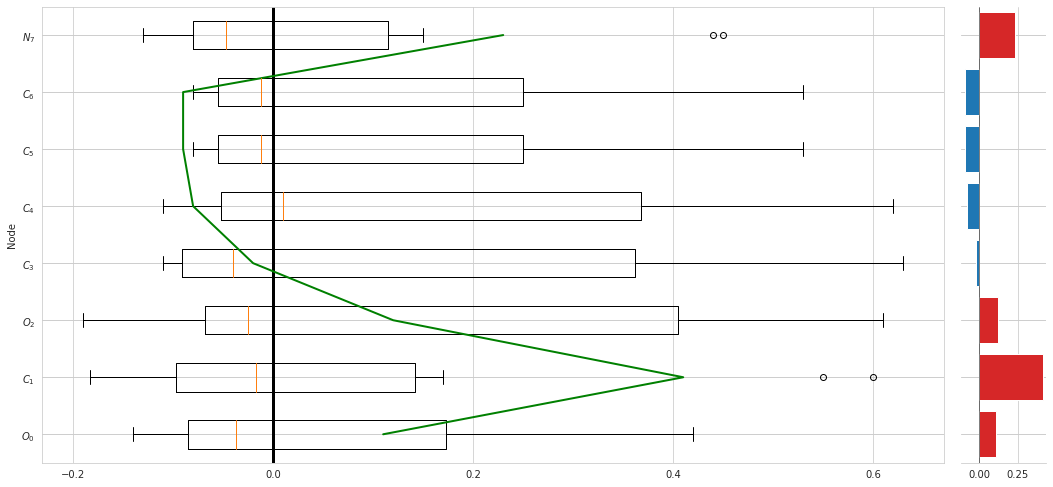

In [21]:
variation_sanity_check(mol, saliency, randomized_saliency, scaler=None, atoms=['C', 'N', 'O', 'S', 'F', 'Cl', 'P', 'Br', 'I'])

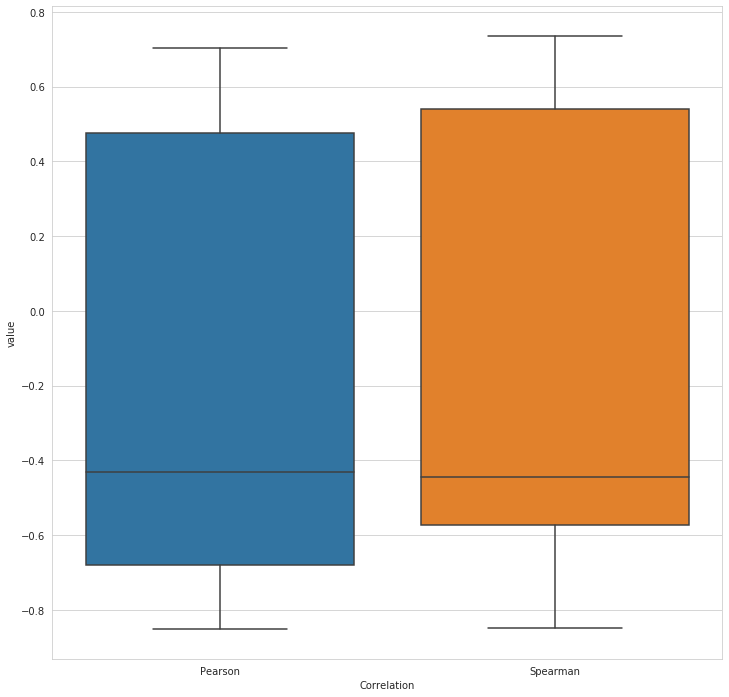

In [22]:
correlation_sanity_check(saliency, randomized_saliency)

## Comparison: RF vs LGB, SimilarityMaps vs SHAP, and Traing vs Test

In [23]:
%%time
rf_cor_df = dataset_cor_df(train_mols, rf_models)
rf_cor_df['algo'] = 'RF'


CPU times: user 2h 58min 31s, sys: 8.89 s, total: 2h 58min 40s
Wall time: 2h 58min 39s


In [24]:
%%time
lgb_cor_df = dataset_cor_df(train_mols, lgb_models)
lgb_cor_df['algo'] = 'LGB'


CPU times: user 3h 23s, sys: 11min 43s, total: 3h 12min 7s
Wall time: 1h 34min 14s


In [25]:
cor_merged = pd.concat([rf_cor_df, lgb_cor_df], axis=0)

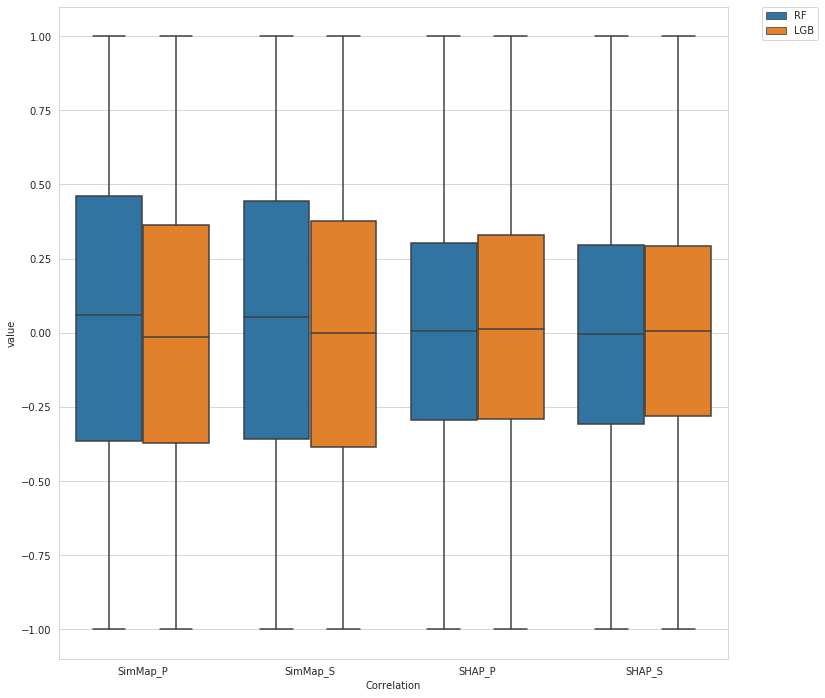

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax = sns.boxplot(x=cor_merged['Correlation'], y=cor_merged['value'], hue=cor_merged['algo'])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [27]:
%%time
rf_cor_df_test = dataset_cor_df(test_mols, rf_models)
rf_cor_df_test['algo'] = 'RF'
lgb_cor_df_test = dataset_cor_df(test_mols, lgb_models)
lgb_cor_df_test['algo'] = 'LGB'
cor_merged_test = pd.concat([rf_cor_df_test, lgb_cor_df_test], axis=0)


CPU times: user 1h 29min 37s, sys: 2min 59s, total: 1h 32min 36s
Wall time: 1h 8min 10s


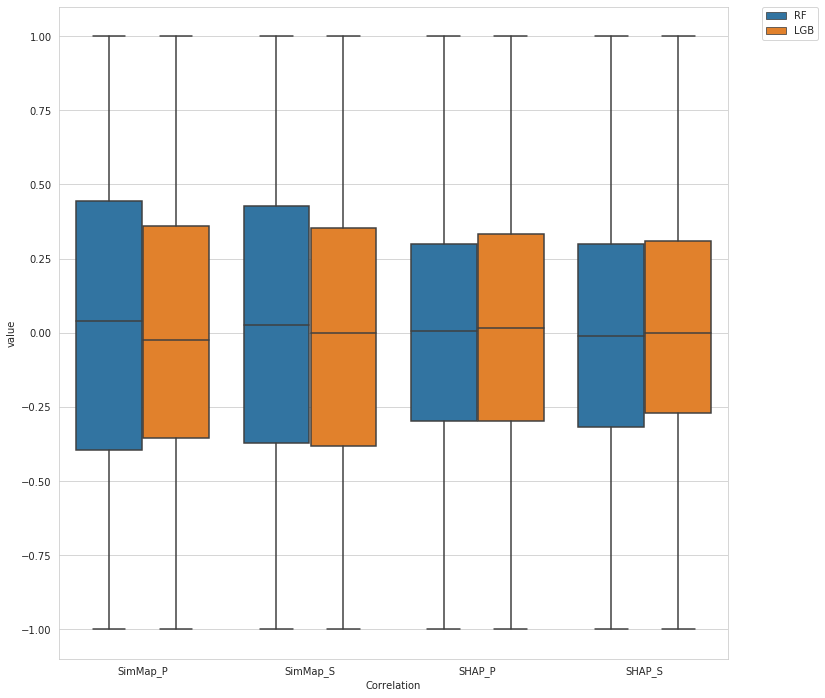

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax = sns.boxplot(x=cor_merged_test['Correlation'], y=cor_merged_test['value'], hue=cor_merged_test['algo'])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [29]:
cor_merged['data'] = 'train'
cor_merged_test['data'] = 'test'
cor_merged_all = pd.concat([cor_merged, cor_merged_test], axis=0)

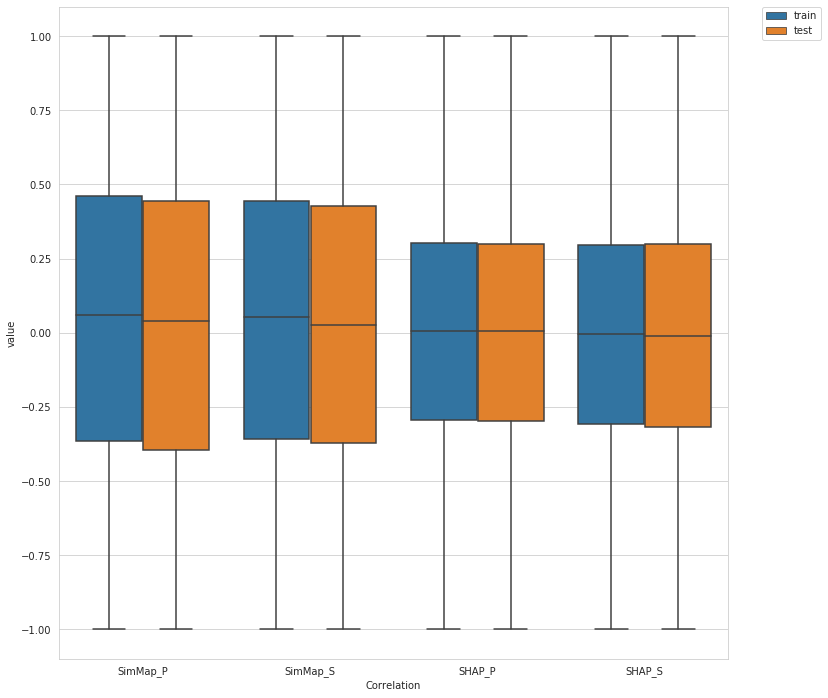

In [31]:
_df = cor_merged_all[cor_merged_all.algo=='RF']
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax = sns.boxplot(x=_df['Correlation'], y=_df['value'], hue=_df['data'])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

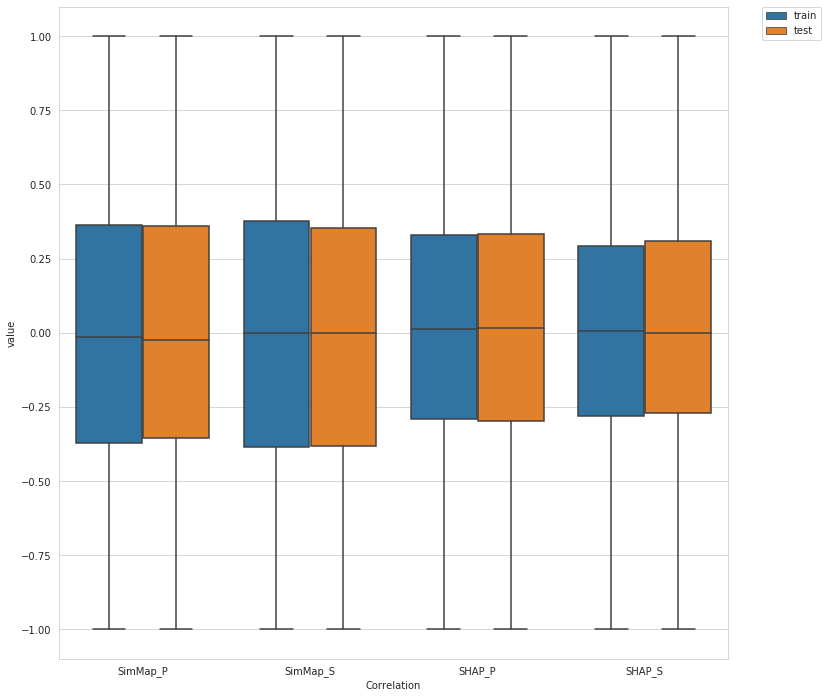

In [32]:
_df = cor_merged_all[cor_merged_all.algo=='LGB']
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax = sns.boxplot(x=_df['Correlation'], y=_df['value'], hue=_df['data'])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [33]:
all_models = {
    'rf': rf_models,
    'lgb': lgb_models,
}

In [34]:
mols = train_mols + test_mols

In [35]:
def _sanity_check_fn(i, algo, weight_fn, method):
    mol = mols[i]
    models = all_models[algo]
    saliency, randomized_saliency = calc_saliency(mol, models[0], models[1:], weight_fn=weight_fn)
    show_pred_results(mol, models[0])
    if method=='visual':
        draw_visual_inspection(mol, saliency, randomized_saliency)
    elif method=='variation':
        variation_sanity_check(mol, saliency, randomized_saliency, scaler=None, atoms=['C', 'N', 'O', 'S', 'F', 'Cl', 'P', 'Br', 'I'])
    elif method=='correlation':
        correlation_sanity_check(saliency, randomized_saliency)
    else:
        raise NotImplementedError()
        
    plt.show()

In [36]:
interact(
    _sanity_check_fn, i=(0, len(mols) - 1, 1), 
    algo=['rf', 'lgb'], weight_fn=['simmap', 'shap'], method=['visual', 'variation', 'correlation']
)
plt.show()

interactive(children=(IntSlider(value=640, description='i', max=1281), Dropdown(description='algo', options=('…